In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
from __future__ import division
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import sys
import unicodedata
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
sns.set_context({'figure.figsize': [12, 7]})
sns.set_context(rc={'lines.markeredgewidth': 0.1})
sns.set_style('white')
sns.set_color_codes()
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.utils import resample
print 'startup script successful'

Populating the interactive namespace from numpy and matplotlib


startup script successful


In [2]:
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

from nltk.stem import WordNetLemmatizer
import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in token_pattern.findall(doc)]
    
def plot_top_words(model, feature_names, topic_idx, n_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
    topic=normalize(model.components_[topic_idx].reshape(1,-1))[0]
    sorted_idx=topic.argsort()[:-n_top_words - 1:-1]
    print("Topic #%d:" % topic_idx)
    features=[feature_names[i] for i in sorted_idx]
    print(" ".join(features))
    ax = sns.barplot(x=range(10),y=topic[sorted_idx])
    feature_id=0
    height= max(topic[sorted_idx])*0.6

    for p in ax.patches:
        ax.text(p.get_x()+0.15, height-0.1, '{}'.format(features[feature_id]))
        feature_id+=1

In [3]:
from nltk.corpus import stopwords
stop_list=stopwords.words('english')+['help','new', 'way', 'world', 'make', 'people']

In [4]:
crunch_data=pd.read_csv('overall_company_list.csv')
kickstart_data=pd.read_csv('proj_list_tech_top200pages_full.csv')
angellist_data=pd.read_csv('results_so_far_2016101710pm.csv')
# unify the column name
kickstart_data.rename(columns={'description':'Description'},inplace=True)
angellist_data.rename(columns={'product_desc':'Description'},inplace=True)
#merge data
merge_data=crunch_data.append([kickstart_data,angellist_data])
# remove \n from descriptions
merge_data['Description']=merge_data['Description'].str.replace('\n',' ')
# merge_data['Description']=merge_data['Description'].str.replace('\\',' ')

merge_data=merge_data.dropna(subset=['Description'])
# turn into graphlab
# startup_data=graphlab.SFrame(merge_data['Description'])
# startup_data.rename({'X1':'Description'})

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2,
                                   max_features=3000,
                                   tokenizer=LemmaTokenizer(),
                                   stop_words=stop_list)
tfidf = tfidf_vectorizer.fit_transform(merge_data['Description'])

In [6]:
nmf = NMF(n_components=15, random_state=1, 
          alpha=.1, l1_ratio=.2, max_iter=5000).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
topic_feature=nmf.transform(tfidf)
topic_feature_norm=normalize(topic_feature)

# Plot the topics 

Topic #0:
user product online customer experience video com use create one
Topic #1:
data big science driven visualization analysis machine insight enterprise learning
Topic #2:
platform engagement management cloud online customer enables audience content advertising
Topic #3:
intelligence artificial machine enterprise competitive human powered ai learning cyber
Topic #4:
analytics predictive provides retail advanced tool healthcare financial sale store
Topic #5:
mobile application app web apps user development device game developer
Topic #6:
social medium network content brand engagement networking discovery audience optimization
Topic #7:
marketing digital agency brand advertising automation marketer performance content sale
Topic #8:
based location cloud user offer game app sharing networking interest
Topic #9:
real time estate insight place delivers information analysis feedback news
Topic #10:
business small customer local intelligence sale insight tool information process
Topic #

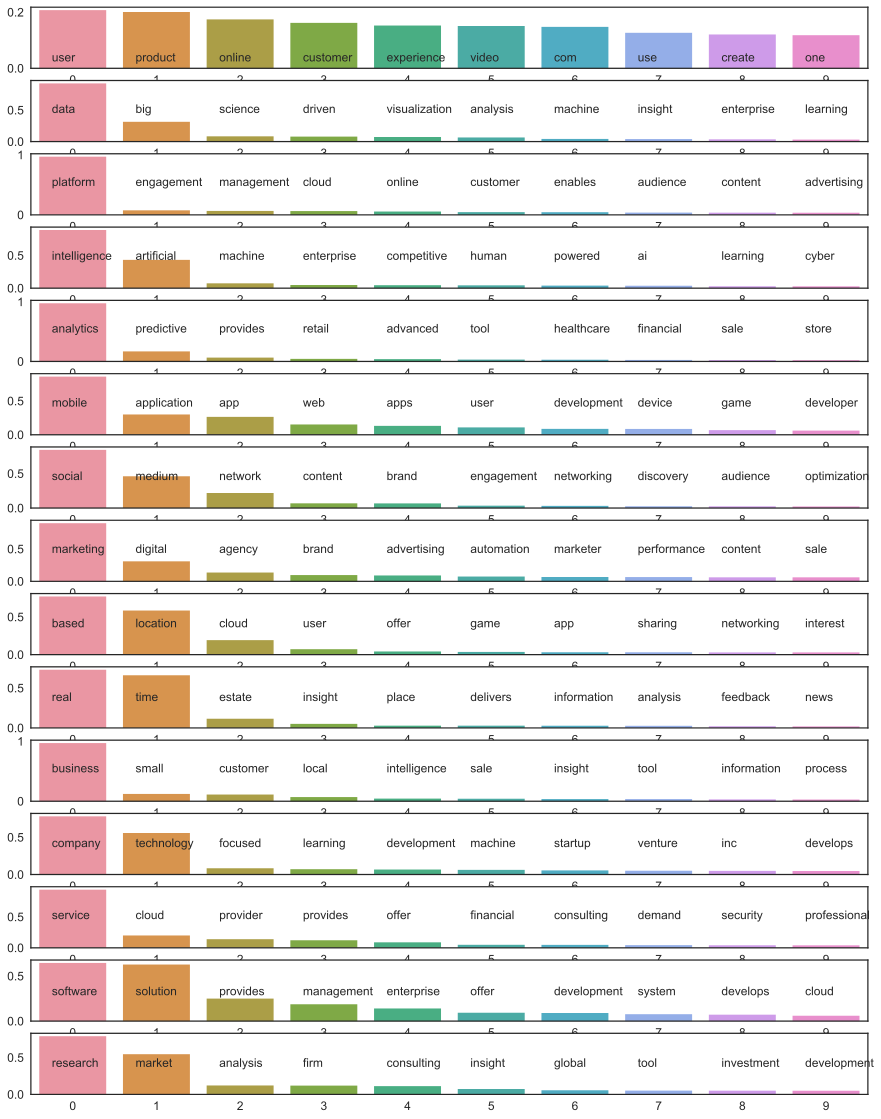

In [7]:
fig=figure(figsize=(15,20))
for i in range(15):
    subplot(15,1,i+1)
    plot_top_words(nmf,tfidf_feature_names,i)

# Cluster the companies 

In [8]:
import itertools
palette = itertools.cycle(sns.hls_palette(15))
markers= itertools.cycle(['x','o','v','^','<','s'])

In [9]:
>>> from sklearn import metrics
>>> from sklearn.metrics import pairwise_distances

In [10]:
def plot_cluster(model, features, tsne_features, feature_names, nmf_model=nmf):
    """
    model: the clustering model. model.labels_ should contain the clusting label
    features: feature vectors used to compute the clustering centroid
    tsne_features: feature vectors for plot with tsne
    """
    cluster_labels=model.labels_
    n_top_words=10
    num_clusters=max(cluster_labels)+1
    # plotting
    # sample 2000 data points for scattering plot
    sample_for_plt, label_for_plt=resample(tsne_features,cluster_labels,n_samples=2000,random_state=0)
    mapping = TSNE(n_components=2,init='random', random_state=0, n_iter=2000, verbose=0, learning_rate=100, perplexity=20)
    embed=mapping.fit_transform(sample_for_plt)
    fig=figure(figsize=(15,7))
    # plot the clusters
    subplot(1,2,1)
    for i in range(num_clusters):
        subgroup=embed[label_for_plt==i,:]
        scatter(subgroup[:,0],subgroup[:,1],s=15, color=next(palette), marker=next(markers), label='{}'.format(i))
    legend()
    # plot the histgram of the clusters 
    subplot(1,2,2)
    hist(cluster_labels)
    # print out the cluster centers
    fig=figure(figsize=(15,10))
    for i in range(max(cluster_labels)+1):
        cluster=features[cluster_labels==i,:]
        centroid=np.mean(cluster,axis=0)
        centroid_feature=centroid.dot(nmf_model.components_)
        sorted_idx=centroid_feature.argsort()[:-n_top_words - 1:-1]
        subplot(num_clusters,1,i+1)
        ax = sns.barplot(x=range(10),y=centroid_feature[sorted_idx])
        top_words=[feature_names[j] for j in sorted_idx]
        word_id=0
        height= max(centroid_feature[sorted_idx])*0.6
        for p in ax.patches:
            ax.text(p.get_x()+0.15, height, '{}'.format(top_words[word_id]))
            word_id+=1
    

In [11]:
def print_cluster_member(model, cluster_id, data, num_samples=10):
    cluster_member=data.iloc[model.labels_==cluster_id]
    print 'number of companies in this class:', len(cluster_member)
    for m in cluster_member.head(num_samples).iterrows():
        print 'company ID:', m[0]
        print m[1]['Description']


## K-mans Clustering

### withoug normalization

In [12]:
n_clusters=10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(topic_feature)
metrics.calinski_harabaz_score(topic_feature, kmeans.labels_) 

1975.7717115955759

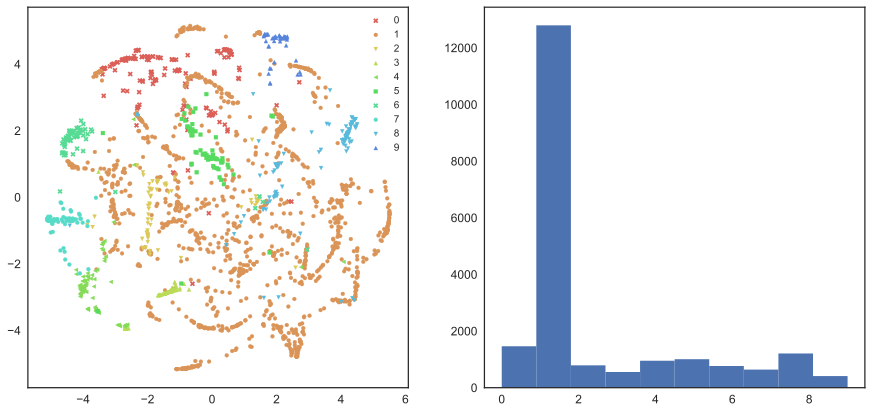

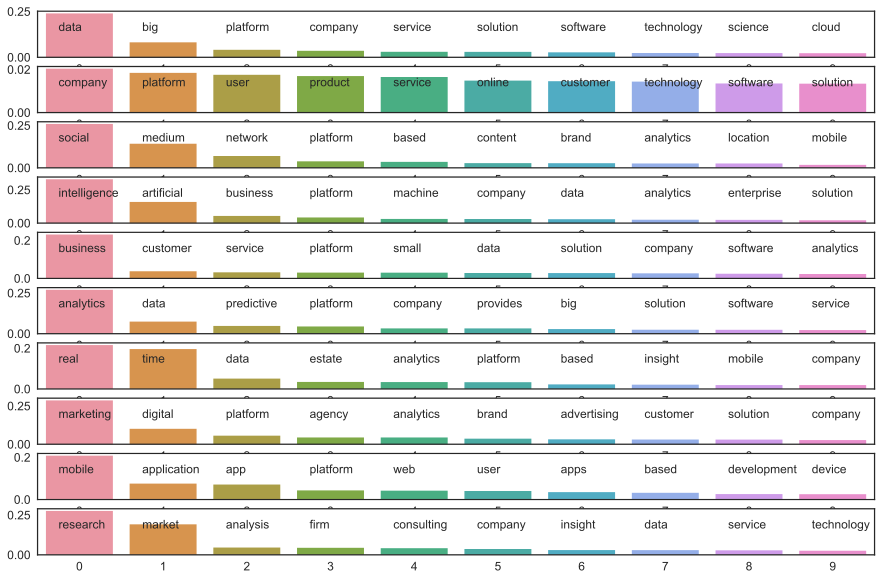

In [13]:
plot_cluster(kmeans, topic_feature, topic_feature, tfidf_feature_names)

In [14]:
# look at one cluster 'artifical intellegence'

In [15]:
print_cluster_member(kmeans, 3, merge_data, 15)

number of companies in this class: 556
company ID: 3
Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.
company ID: 21
Advanced medication adherence solutions powered by artificial intelligence
company ID: 27
FirstFuel provides an analytics based customer intelligence platform for utilities and energy service providers
company ID: 39
Meta is an Artificial Intelligence that continuously maps and monitors the universe of science, as well as its future horizons.
company ID: 45
Profitero is a next-generation pricing intelligence service for retailers and manufacturers
company ID: 48
WireX Systems provides cyber intelligence solutions.
company ID: 66
AYLIEN is an Artificial Intelligence startup, focused on creating technologies that help machines understand humans better.
company ID: 94
Pick1 offers a survey and marketing intelligence suite to deliver actionable data for businesses.
company ID: 98
Blue Health Intelligence accesses th

### with normalization

In [16]:
# normalize the topic feature vector is equivalent to use cosine distance

In [17]:
n_clusters=15
kmeans_norm = KMeans(n_clusters=n_clusters, random_state=0).fit(topic_feature_norm)
metrics.calinski_harabaz_score(topic_feature_norm, kmeans_norm.labels_) 

3555.3367802345665

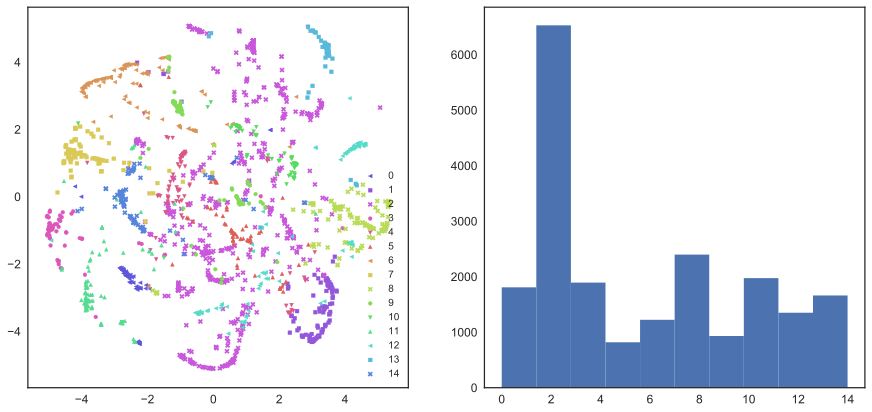

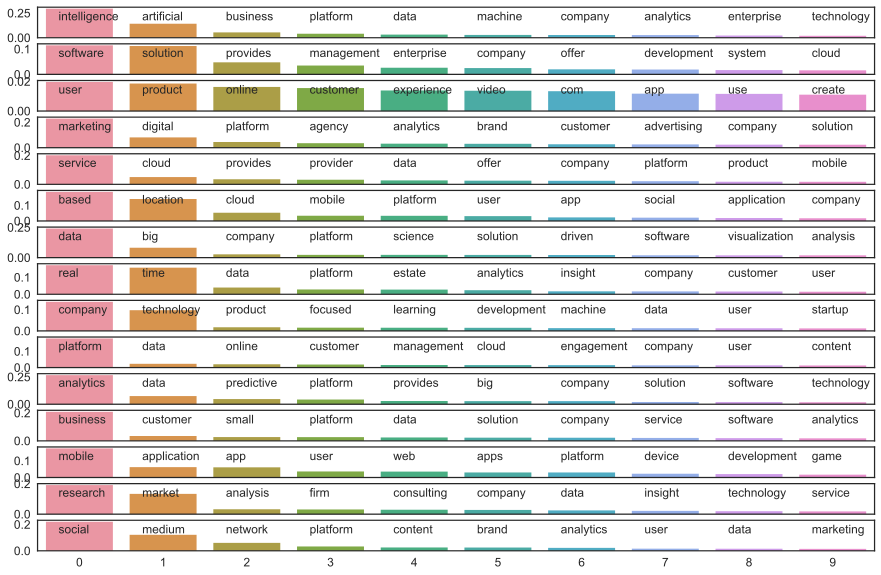

In [18]:
plot_cluster(kmeans_norm, topic_feature, topic_feature_norm, tfidf_feature_names)

In [19]:
print_cluster_member(kmeans_norm, 0, merge_data, 15)

number of companies in this class: 678
company ID: 2
Sumo Logic, a log management and analytics service, transforms big data into sources of operations, security and compliance intelligence.
company ID: 3
Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.
company ID: 21
Advanced medication adherence solutions powered by artificial intelligence
company ID: 27
FirstFuel provides an analytics based customer intelligence platform for utilities and energy service providers
company ID: 39
Meta is an Artificial Intelligence that continuously maps and monitors the universe of science, as well as its future horizons.
company ID: 43
StreetLight Data delivers next-generation geospatial business intelligence to support critical decisions and improve return on investment.
company ID: 45
Profitero is a next-generation pricing intelligence service for retailers and manufacturers
company ID: 48
WireX Systems provides cyber intelligence solution

## Agglomerative clustering

In [20]:
from sklearn.cluster import AgglomerativeClustering

In [21]:
agg= AgglomerativeClustering(n_clusters=15, linkage='ward')
agg.fit(topic_feature_norm)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=15,
            pooling_func=<function mean at 0x10efe22a8>)

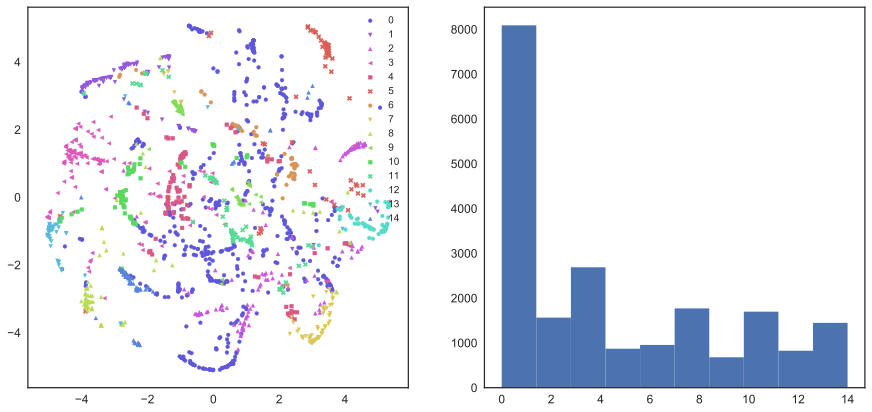

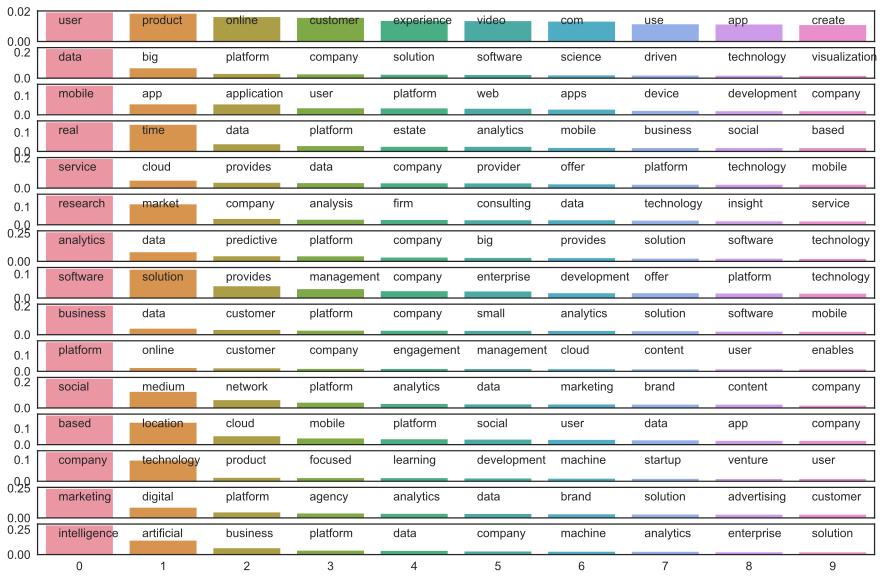

In [22]:
plot_cluster(agg, topic_feature, topic_feature_norm, tfidf_feature_names)

In [23]:
print_cluster_member(agg, 12, merge_data, 200)

number of companies in this class: 825
company ID: 20
Comprehend is a technology company with a new class of cloud software to help ClinOps teams continuously improve speed and quality.
company ID: 28
Slice Technologies is online shopping, smarter.
company ID: 63
AchieveIt delivers innovative technology that empowers leaders with the visibility to coordinate team performance and drive results.
company ID: 74
DigitalMR is a tech company that uses A.I. for customer insights
company ID: 75
Aditazz designs and delivers next-generation healthcare facilities by integrating new design, technology and manufacturing techniques.
company ID: 95
Abcodia is an innovative biotech company engaged in the validation and discovery of molecular biomarkers.
company ID: 108
Imbed Biosciences is a Privately held medical device company .
company ID: 124
Neumitra develops connected technologies to address the effects of stress on brain health and performance.
company ID: 143
SocialCode is a technology and ins

In [24]:
from sklearn.neighbors import NearestNeighbors

In [25]:
neigh = NearestNeighbors(20, 0.4)
neigh.fit(topic_feature_norm) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=0.4)

In [26]:
def query_company(id, knn_model=neigh, data_set=merge_data, X=topic_feature_norm):
    k=10
    print 'query id:', id
    print data_set.iloc[id]['Description']
    print '-'*50
    distances, indices = knn_model.kneighbors(X[id].reshape(1, -1),n_neighbors=k)
    for i in range(1,k):
        print '{}st neighbor: id {}, with distance {}'.format(i,indices[0][i],distances[0][i])
        print  data_set.iloc[indices[0][i]]['Description']
        print 

In [27]:
query_company(3598)

query id: 3598
Self-learning DSP for Mobile
--------------------------------------------------
1st neighbor: id 3598, with distance 0.0
Self-learning DSP for Mobile

2st neighbor: id 12991, with distance 0.0209909574986
A mobile encyclopedia for discovering and learning about craft beer and breweries.

3st neighbor: id 9205, with distance 0.0766306987202
Computer vision applications for mobile devices

4st neighbor: id 9547, with distance 0.0795676036204
Fingertips Lab has created an exciting new way of interacting with mobile applications

5st neighbor: id 2421, with distance 0.0856184419389
Web and Mobile Design

6st neighbor: id 788, with distance 0.0856812242308
ZIMPERIUM is a mobile security startup that offers protection for mobile devices against the next generation of advanced mobile attacks.

7st neighbor: id 14725, with distance 0.0884715292843
Help Handy Bikes DC bring a self-contained, efficient & agile mobile bicycle repair truck to the streets of DC.

8st neighbor: id 334

In [28]:
merge_data.iloc[3598]

Categories                                          Big Data, Mobile Advertising
Category Groups                Data and Analytics, Sales and Marketing, Adver...
Closed Date                                                                  NaN
Company Name                                                   Deep Forest Media
Crunchbase Rank                                                           10,010
Description                                         Self-learning DSP for Mobile
Founded Date                                                          2012-01-01
Headquarters Location                       Palo Alto, California, United States
IPO Date                                                                     NaN
Last Equity Funding Amount                                            $1,710,072
Last Funding Amount                                                   $1,710,072
Last Funding Date                                                     2014-12-31
Money Raised at IPO         